#### David Palumbo
#### Aero/Hydro Dynamics MAE 6226
#### Due: 5/7/2018
# Ground Effect on Under-Cambered Airfoil Modeled by the Panel Method

## 1) Introduction
<br> In this project, we are hoping to understand the nature of the ground effect on an undercambered airfoil in a freestream flow. To accomplish this task, we will be writing a code that combines several ideas from previous AeroPython lessons.  Earlier in the class, we have witnessed the strengths of the panel method when developing highly-accurate flow models for airfoils in open space. We have also touched upon the method of images when simulating flow near a wall. We now look to combine these methods to simulate the ground effect on airfoils in steady potential flow.<br>

The airfoil that we would like to examine is the Karman Trefftz airfoil that we saw in the midterm. This type of airfoil is under-cambered in geometry, meaning that the bottom surface has a cambered shape. This shape is designed to allow higher lift coefficients at relatively low speeds, and we know this because the cambered top and bottom surfaces will create a higher pressure differential.  While we are using an under-cambered airfoil in this example, but this code can be used to run symmetrical and flat-bottomed airfoils as well.

The flow conditions for each trial will be the same except for the isolated variable of ground height.  Otherwise, all flow will be potential, the freestream velocity will always be a value of 1.0 along the x direction, and the angle of attack will always be 0.0 degrees.  To show the ground effect's affect on the flow around an airfoil, we will be plotting pressure field and velocity field, and we will be running a comparitive lift study.



![title](airfoil_ng.png)<br> <center>Figure 1. Airfoil in Flow without Ground Effect. <br>The yellow areas represent relatively high pressures, while the blue illustrates relatively low pressure.
![title](airfoil_g.png)<br> Figure 2. Airfoil in Flow with Ground Effect. <br> The yellow areas represent relatively high pressures, while the blue illustrates relatively low pressure.
![title](heightgraph.png)<br> Figure 3. Height versus Coefficient of Lift<br>
We see in this graph that the coefficient of lift increases with decreasing height.

## 2) Experimental Setup
Before we can begin anything else, we have to set up our various classes and functions to get the ball rolling. Like we have said before, we want to use the panel method to set up our airfoils, so we will naturally use the Panel class to define the geometry of each airfoil. The panel method works by initializing the start and end points of each panel. Each panel is a function of the start point (x[i],y[i]) and the end point (x[i+1],y[i+1]) given by the original text file. It then calcualates the center point of each panel along with the panel's length. It assigns an angle beta to each panel based upon the panel's angle from the horizontal 0-degree mark.  If the panel happens to be on the upper surface of the airfoil, the angle beta will be less than 180 degrees, but the panels on the lower surface will have a beta value between 180 and 360 degrees. If a number N is the number of x coordinates in the original text file, we will have N-1 panels overall.

In addition to the geometry of the panels, each panel is allocated variables for coefficient of pressure, tangential velocity, and source/vortex strength.  These will be filled later with additional functions. 
 

In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib 
from matplotlib import pyplot as plt
import scipy
from scipy import integrate

class Panel:

    def __init__(self,xa,ya,xb,yb):
        self.xa,self.ya = xa,ya
        self.xb,self.yb = xb,yb
        self.xc, self.yc = (xa + xb)/2, (ya+yb)/2
        self.length = np.sqrt((xb-xa)**2 + (yb-ya)**2)
        
        if xb -xa <= 0.0:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + math.acos(-(yb -ya)/self.length)
        
        if self.beta <= math.pi:
            self.loc ='upper'
        else:
            self.loc ='lower'
        self.sigma =0.0
        self.vt =0.0
        self. cp =0.0
        
def define_panels(x,y):
    
    N = x.size-1
    panels = np.zeros(N,dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i], x[i+1], y[i+1])
        
    return panels 

The Freestream class allows us to define a freestream velocity and angle of attack. Again, the velocity will remain steady at 1.0 in the x direction, and the angle of attack wil remain at 0.0 degrees.  Unless specified, Python uses radians as a standard for calculating angle-based math, so in general, we convert alpha from degrees into radians in this function.

In [2]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  

The next function that we define is the integral function.  This allows us to find the contribution from one point along a panel. We will later use this function to help us fill the singularity matrix. 

In [3]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [4]:
def source_contribution_normal(panels):
  
    A = np.zeros((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

Because the Karman Trefftz airfoil is a lift-generating airfoil, we expect to experience non-physical flow over the tail. As the Kutta condition will not be met with source contriubtion alone, a vortex contribution must be added to the trailing edge to make the flow physical. We can take these contributions and combine them to create our singularity matrix to solve for airfoil strengths. 

In [5]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.zeros((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [6]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [7]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta) )
    return b

# function for tangential velocity 



In [8]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

### <center> Loading Karman Trefftz Airfoil

Here we upload the karman trefftz airfoil from the directory and assign its point coordinates to the variables x and y. We then define the panels for the airfoil and plot it out.  

In [10]:
info = np.loadtxt('karmantrefftz_data.txt')
x  = info[:,0]
y = info[:,1]


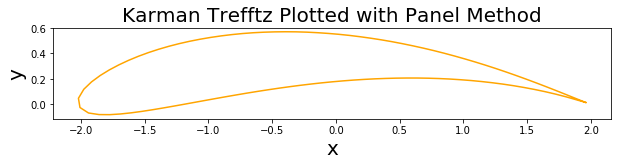

In [11]:
panels = define_panels(x,y)
plt.figure(figsize=(10,10))

plt.plot(np.append([p.xa for p in panels],panels[0].xa),np.append([p.ya for p in panels],panels[0].ya),color='orange')


plt.axis('scaled')
plt.title('Karman Trefftz Plotted with Panel Method',fontsize=20)
plt.xlabel('x',fontsize=20)
plt.ylabel('y',fontsize=20)

u_inf = 1.0
alpha = 0.0


Next, we have to solve for the sources and vortex of the airfoil system. To do this, we need to solve an (A)(sigma) =(b) relationship by calling the functions that we have defined in the previous cells. Once we have the all the strengths calculated, we can next solve for the control pressure and tangential velocities.

In [12]:
freestream = Freestream(u_inf,alpha)
A_source= source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [13]:
A = build_singularity_matrix(A_source,B_vortex)
b = build_freestream_rhs(panels, freestream)

In [14]:
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]



In [15]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

Here, we establish the tangential velocity and pressure coefficients along the panels by calling the functions that we have previously defined. We also establish a new function here called "getVelocityField_partial", which finds the source-based velocity field of the system. We need this later to help define our mirrored image. Next, since we have enough information to calculate lift of the airfoil with no ground effect, we can solve for it using our newly-found tangenetial velocities and coefficients of pressure.  This will serve as our control lift, and we expect that each trial we simulate with the ground effect will have a greater value than the control.

In [16]:
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
def getVelocityField_partial(panel,freestream,X,Y):
    Nx,Ny = X.shape
    u,v = np.empty((Nx,Ny),dtype=float),np.empty((Nx,Ny),dtype=float)
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = 0.5/np.pi*sum([p.sigma*integral(X[i,j],Y[i,j],p,1,0) for p in panel])
            
           
            
            v[i,j] = 0.5/np.pi*sum([p.sigma*integral(X[i,j],Y[i,j],p,0,1) for p in panel])\
         
        
    return u,v


lift_c = 0
for panel in panels:
    lift_c -= panel.cp*panel.length*np.sin(panel.beta)
lift_c


4.0911420576143387

We have just found our control lift at a value of 4.09. This will serve as a reference to the lift that we attain from the ground effect trials.

We have just established a function for the velocity field using just the source contribution. Now we will define a function for the velocity field using just the vortex contributions and a function that solves the velocity field using the freestream, the sources, and the vortex. These will help us in our future mapping.

In [17]:
def getVelocityField(panel,freestream,X,Y,gamma):
    Nx,Ny = X.shape
    u,v = np.empty((Nx,Ny),dtype=float),np.empty((Nx,Ny),dtype=float)
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = freestream.u_inf*np.cos(freestream.alpha)+0.5/np.pi*sum([p.sigma*integral(X[i,j],Y[i,j],p,1,0) for p in panel])\
            -0.5*gamma/np.pi*sum([integral(X[i,j],Y[i,j],p,0,-1) for p in panel])\
            
           
            
            v[i,j] = freestream.u_inf*np.sin(freestream.alpha)+0.5/np.pi*sum([p.sigma*integral(X[i,j],Y[i,j],p,0,1) for p in panel])\
            -0.5*gamma/np.pi*sum([integral(X[i,j],Y[i,j],p,1,0) for p in panel])
            
           
    return u,v
def getVelocityField_vortex(panel,freestream,X,Y,gamma):
    Nx,Ny = X.shape
    u,v = np.empty((Nx,Ny),dtype=float),np.empty((Nx,Ny),dtype=float)
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = -0.5*gamma/np.pi*sum([integral(X[i,j],Y[i,j],p,0,-1) for p in panel])\

            
            v[i,j] = -0.5*gamma/np.pi*sum([integral(X[i,j],Y[i,j],p,1,0) for p in panel])
            
           
    return u,v

It is now time to create the ground effect using the method of images.  The first thing that we do is create a 100 by 100 meshgrid. At each point in the grid, we will be solving for the velocity contributions from the freestream, the airfoil, and the mirrored airfoil. This system will give us a simulated ground effect. It is noted that this is a uniform meshgrid and that velocity accuracy is a function of distance from the ground.  

In [18]:
def solve_ground_effect(panels,freestream,gamma,dist):
    Nx,Ny = 100,100


    X,Y = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-dist-2,2,Ny))
    u_source, v_source = getVelocityField_partial(panels,freestream,X,Y)
    u_vor, v_vor= getVelocityField_vortex(panels,freestream,X,Y,gamma)
    u_vor_mir,u_source_mir= np.zeros_like(u_source),np.zeros_like(u_source)
    v_vor_mir,v_source_mir = np.zeros_like(v_source),np.zeros_like(v_source)
    
    for i in range(u_source.shape[0]):
        u_source_mir[i,:] = u_source[int(u_source.shape[0]-1)-i,:]
        v_source_mir[i,:] = -v_source[int(v_source.shape[0]-1)-i,:]

        u_vor_mir[i,:] = u_vor[int(u_source.shape[0]-1)-i,:]
        v_vor_mir[i,:] = -v_vor[int(u_source.shape[0]-1)-i,:]
    
    
    u,v = getVelocityField(panels,freestream,X,Y,gamma)
    
    ut = u_inf*np.ones_like(u_source) + u + u_source_mir + u_vor_mir
    vt =   v + v_source_mir + v_vor_mir
    
    return ut,vt
    
    






In [19]:
ut3,vt3 = solve_ground_effect(panels,freestream,gamma,3)
ut2,vt2 = solve_ground_effect(panels,freestream,gamma,2)
ut1,vt1 = solve_ground_effect(panels,freestream,gamma,1)
# ut10,vt10 = solve_ground_effect(panels,freestream,gamma,10)
    

In [67]:
Nx,Ny =100,100
X,Y = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-2,2,Ny))
ut, vt = getVelocityField(panels,freestream,X,Y,gamma)

## 3) Results

In this section, we will illustrate the flow patterns of several test cases. Our first case is the control scenario where the airfoil is not affected by the ground effect. In this case, we do not employ the method of images. The next three cases incorporate the ground effect at various heights from the ground (distances of 0.5, 1.0, and 1.5). In each of these cases, we intend to display comparitive flow visualization tools such as streamline plotting and pressure contour mapping.

Aside from the visual aids, we also want to compare quantitative data in each trial. The most important parameter that we are interested in is, of course, lift.  The control lift has already been calculated earlier in the code, as we saw. This was found using the pressure coefficients on the panels themselves. However, when we calculate the trials that use the ground effect, we are no longer using points on the panels themselves, but we are instead using points on the meshgrid.

Therefore, to estimate the approximate coefficients of pressure along the airfoil's surface, we need to create estimator points that are as close as possible without straying inside the bounds of the airfoil.  We will get to this later, but it will require us to create a function that determines acceptable and unacceptable grid points.

The first things that we would like to display are the stream plots of each trial.  We have already collected the u and v terms for each point in the mesh, and even though we use the same number of points in the x and y directions, we will see a distinct difference in resolution depending on the range in y that we have chosen.  The control case has the highest resolution because it calculates 100 grid points in a relatively short range (between y=-2 and y =2). Compared to the ground effect trials that have to calculate from a lower y range, the control case has a denser mesh around the airfoil.  This means that as we increase the distance from the ground in the ground effect trials, we become less and less accurate since we use a uniform grid.


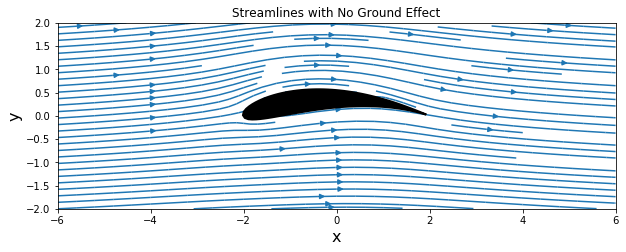

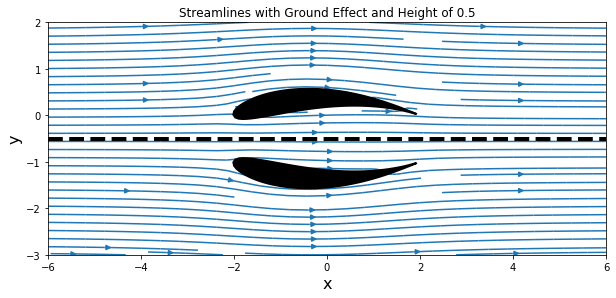

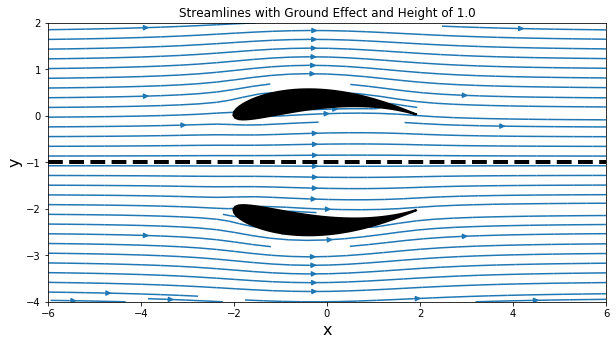

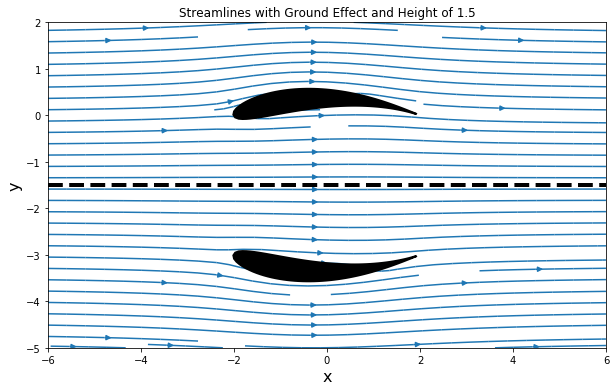

In [79]:


Nx =100
Ny=100


# X10,Y10 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-12,2,Ny))

X3,Y3 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-5,2,Ny))
X2,Y2 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-4,2,Ny))
X1,Y1 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-3,2,Ny))

# plot the pressure field
width = 10
plt.figure(figsize=(width, width))

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

plt.streamplot(X, Y, ut,vt)

plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.title('Streamlines with No Ground Effect')

############################################
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.streamplot(X1, Y1, ut1,vt1)
plt.axhline(-0.5, color='k', linestyle='--', linewidth=4);

plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)

plt.fill([panel.xc for panel in panels],
            [-panel.yc-1 for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.title('Streamlines with Ground Effect and Height of 0.5')



# ####################################################################
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.axhline(-1.0, color='k', linestyle='--', linewidth=4);
plt.streamplot(X2, Y2, ut2,vt2)

plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.fill([panel.xc for panel in panels],
            [-panel.yc-2 for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.title('Streamlines with Ground Effect and Height of 1.0')

# ###################################################################
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.axhline(-1.5, color='k', linestyle='--', linewidth=4);
plt.streamplot(X3, Y3, ut3,vt3)

plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.fill([panel.xc for panel in panels],
            [-panel.yc-3 for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.title('Streamlines with Ground Effect and Height of 1.5')


# ######################################################


We have seen that the streamplot looks much cleaner in the control case, but the ground effect cases still maintain a close approximation to what is expected in the streamplots. We will now use the values for u and v that we have previously calculated and displayed here to find our coefficients of pressure.  We will plot contour maps of the pressure to illustrate the general pressure distribution. We have scaled each of the ground effect trials between -5 and 0 for coefficient of pressure, as the baseline coefficients of pressure in these cases are lower than the control case, which we have scaled between -2 and 1. In doing this, we have kept the scale of the ground effect cases consistant, but we also display a similar range of colors in the control.

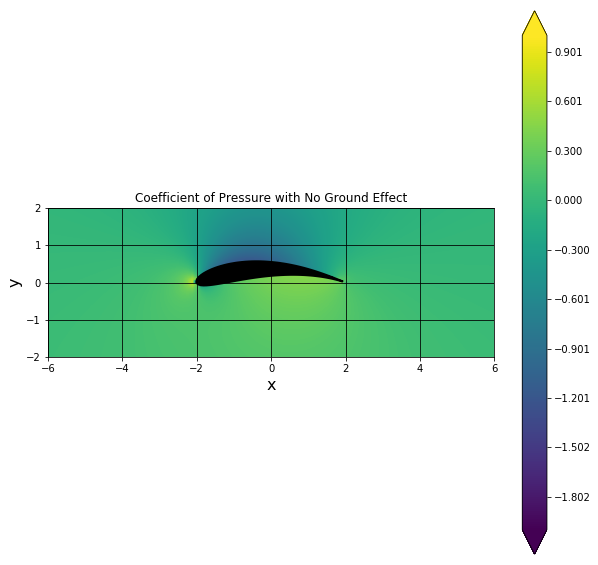

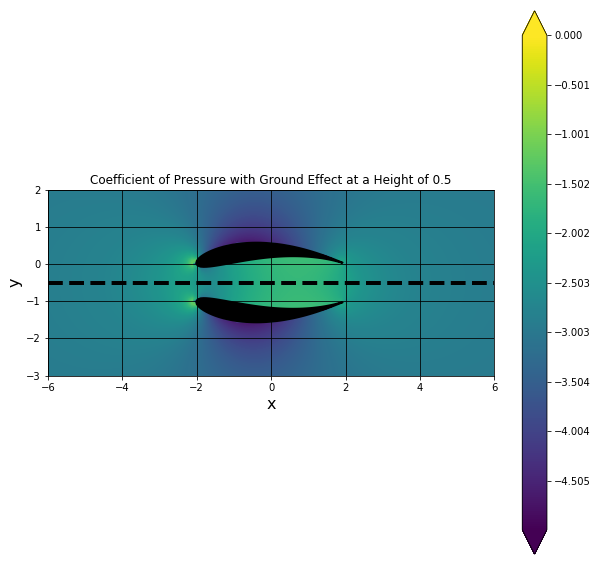

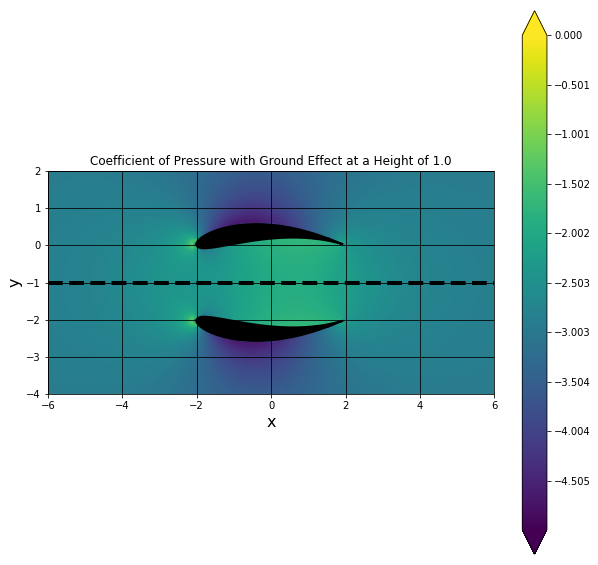

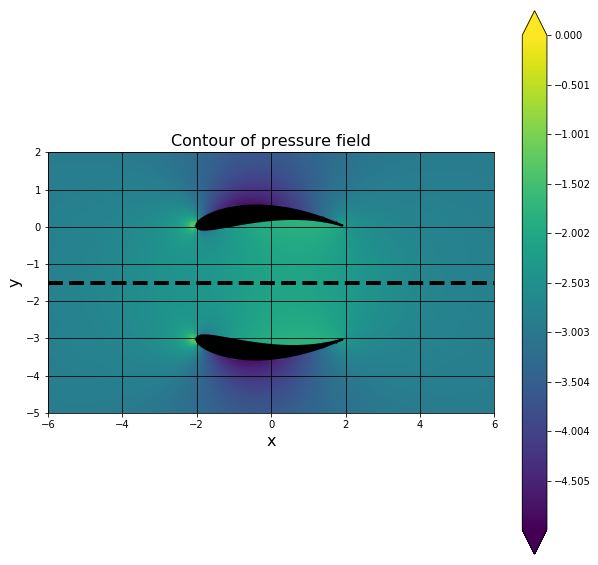

In [81]:

cp =1.0 - ((ut**2 + vt**2) / u_inf**2)

cp3 = 1.0 - ((ut3**2 + vt3**2) / u_inf**2)
cp2 = 1.0 - ((ut2**2 + vt2**2) / u_inf**2)
cp1 = 1.0 - ((ut1**2 + vt1**2) / u_inf**2)

Nx =100
Ny=100


# X10,Y10 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-12,2,Ny))

X3,Y3 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-5,2,Ny))
X2,Y2 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-4,2,Ny))
X1,Y1 = np.meshgrid(np.linspace(-6,6,Nx),np.linspace(-3,2,Ny))

# plot the pressure field
width = 10

plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

contf = plt.contourf(X, Y, cp,   levels=np.linspace(-2, 1, 1000), extend='both')
cbar = plt.colorbar(contf,orientation='vertical')
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.grid(color='k')



plt.axis('scaled', adjustable='box')
plt.title('Coefficient of Pressure with No Ground Effect')

###########################################################
plt.figure(figsize=(width, width))

plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
contf = plt.contourf(X1, Y1, cp1,   levels=np.linspace(-5, 0, 1000), extend='both')
cbar = plt.colorbar(contf,orientation='vertical')
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.grid(color='k')
plt.axhline(-0.5, color='k', linestyle='--', linewidth=4);

plt.fill([panel.xc for panel in panels],
            [-panel.yc-1 for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.title('Coefficient of Pressure with Ground Effect at a Height of 0.5')
# ####################################################################
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
contf = plt.contourf(X2, Y2, cp2,   levels=np.linspace(-5, 0, 1000), extend='both')
cbar = plt.colorbar(contf,orientation='vertical')
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.grid(color='k')
plt.axhline(-1.0, color='k', linestyle='--', linewidth=4);

plt.fill([panel.xc for panel in panels],
            [-panel.yc-2 for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.title('Coefficient of Pressure with Ground Effect at a Height of 1.0')

###################################################################
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
contf = plt.contourf(X3, Y3, cp3,   levels=np.linspace(-5, 0, 1000), extend='both')
cbar = plt.colorbar(contf,orientation='vertical')
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.grid(color='k')
plt.axhline(-1.5, color='k', linestyle='--', linewidth=4);

plt.fill([panel.xc for panel in panels],
            [-panel.yc-3 for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.title('Coefficient of Pressure with Ground Effect at a Height of 1.5')

######################################################


#####################################

# plt.scatter(X[42,33],Y[42,33],color='red')




plt.title('Contour of pressure field', fontsize=16);

We have now depicted the pressure contours for each case, and while these accuarately show the pressure distributions, it is difficult to see distinct differences in patterns. This is why we are also interested in quantitative data like lift.  As discussed earlier, we need a new function to find estimator points that lie outside the boundaries. This idea is slightly inspired by imersed boundary methods that are used in visous CFD program.  The idea is that we want to find the closest grid point for each point along the airfoil. We know that some of the closest points may lie inside the boundaries of the airfoil, but the pressures there are obviously non-physical. To get points that are always outside of this boundary, we find upper and lower index points in y along the surface of the airfoil.  

We trace along the surface of the airfoil using the points that we uploaded directly from the text file. If the point lies on the upper surface of the airfoil, we calculate all y indecies that are beneath it. We then take a point on the lower surface of the airfoil with a similar x coordinate and find all y indecies higher than that point. With this information, we can make a list of every y index that falls in the range of the airfoil. If the first point's closest estimator point is within this list, we then pick the next closest point.  This corrective technique is only employed in the y direction, but if we pick a close x value first, we can correct in the y direction with relative ease.

In [24]:
def get_outer_points(panels,x,y,X,Y,cp):
    locs = np.zeros((x.shape[0]),dtype=object)
    cpb = np.zeros((x.shape[0]),dtype=float)
    xb = np.zeros((x.shape[0]),dtype=float)
    yb = np.zeros((x.shape[0]),dtype=float)
    check = np.empty((1),dtype=object)

    for i, panel in enumerate(panels):
        locs[i] = panel.loc
    locs[-1]='lower'

    x_start = np.max(np.where((X[0]-np.min(x))<0))
    x_end = np.min(np.where((X[0]-np.max(x)>0)))

    for i in range(x.shape[0]):

        if locs[i] == 'upper':
            YL = np.where(Y[:,0]-y[i]<0)
        elif locs[i] == 'lower':
            YU = np.where(Y[:,0]-y[i]>=0)
        if locs[int(x.shape[0]-1-i)] =='lower':
            YU= np.where(Y[:,0]-y[int(Y.shape[0]-1-i)]>=0)
        elif locs[int(x.shape[0]-1-i)] =='upper':
            YL =  np.where(Y[:,0]-y[int(Y.shape[0]-1-i)]<0)
    #     print(YL)
    #     print(YU)
#         print(np.intersect1d(YL, YU))
    
        Xset = np.linspace(x_start,x_end,x_end-x_start+1)

        closex = np.abs((X[0]-x[i]))
        indx =   np.where(np.abs((X[0]-x[i]))==np.min(np.abs((X[0]-x[i]))))

        closey =  np.abs((Y[:,0]-y[i]))
        indy =np.where(np.abs((Y[:,0]-y[i]))==np.min(np.abs((Y[:,0]-y[i]))))  
      
        check = indy in np.intersect1d(YL, YU)

        if check == True:
            indy = np.where(np.abs((Y[:,0]-y[i]))==sorted(closey)[1])
            check = indy in np.intersect1d(YL, YU)
        if check == True:
            indy = np.where(np.abs((Y[:,0]-y[i]))==sorted(closey)[2])
            check = indy in np.intersect1d(YL, YU)
       



        xb[i] = X[indy,indx]  
        yb[i] = Y[indy,indx]
        cpb[i] = cp[indy,indx]

    return xb,yb,cpb

We now call all of our estimator points for the ground effect trials, and we plot them around a map of the airfoil to show that almost all of them fall outside of the boundary. Again, since we are using a uniform meshgrid, the resolution of the estimator points is generally determined by the height from the ground. However, this method has given us fairly clean resolution for every trial with the exception of a few points that fall in the bounds. These bad points will be dealt with next.

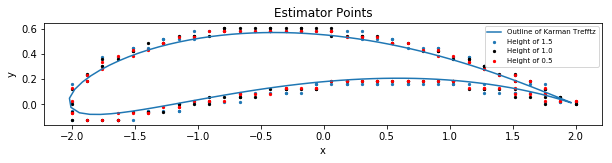

In [48]:


xb3,yb3,cpb3 = get_outer_points(panels,x,y,X3,Y3,cp3)
xb2,yb2,cpb2 = get_outer_points(panels,x,y,X2,Y2,cp2)
xb1,yb1,cpb1 = get_outer_points(panels,x,y,X1,Y1,cp1)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.scatter(xb3,yb3,s=5)
plt.scatter(xb2,yb2,s=5,color='k')
plt.scatter(xb1,yb1,s=5,color='r')
plt.plot(x,y)
plt.axis('scaled')
plt.legend(['Outline of Karman Trefftz','Height of 1.5','Height of 1.0','Height of 0.5'],loc='upper right',fontsize=7)
plt.title('Estimator Points')
plt.ylabel('y')
plt.xlabel('x')




Because a couple bad points may have slipped through the cracks, we need to create a method of replacing those points with more accurate values. In the next function, we indentify any points with pressures lower than -5. Unusually low pressures are a product of non-physical meaurements that lie within the bounds of the airfoil. Any point with pressure this low is automatically replaced with the pressure at the next point in the pressure array.  Because we don't have a lot of points inside the airfoil boundaries already, this method cleans up the pressure very nicely. However, this does affect our accuracy. 

In [27]:
def compute_pressure_coefficient_2(panels, cpb):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for i, panel in enumerate(panels):
        if cpb[i]>-5:
            panel.cp = (cpb[i])
        else:
            panel.cp = cpb[i+1]

We can now take the coefficients that we have found and plug them into a function that 

In [78]:
def lift(cpb,panels):
    lift = np.empty(panels.shape[0])
    L = 0
    for i, panel in enumerate(panels):
        L -= panel.cp*panel.length*np.sin(panel.beta)
#         print(panel.cp)
    return L 
compute_pressure_coefficient_2(panels, cpb3)
lift3 = lift(cpb3,panels)

compute_pressure_coefficient_2(panels, cpb2)
lift2 = lift(cpb2,panels)

compute_pressure_coefficient_2(panels, cpb1)
lift1 = lift(cpb1,panels)



# compute_pressure_coefficient_2(panels, cpb20)
# lift20 = lift(cpb20,panels)
print('Total lift at a height of 1.5 is',lift3)
print('Total lift at a height of 1.0 is',lift2)
print('Total lift at a height of 0.5 is',lift1)
print('Total lift with No Ground Effect is',lift_c)



Total lift at a height of 1.5 is 7.51075345077
Total lift at a height of 1.0 is 7.44201332084
Total lift at a height of 0.5 is 7.64967332826
Total lift with No Ground Effect is 4.09114205761


(0.11299627134102658,
 0.38920937906353603,
 1.8165172990360778,
 1.8723515880789827)

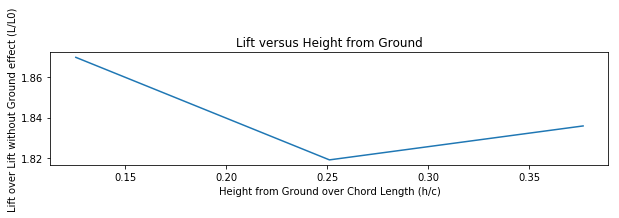

In [37]:
c = np.max(x)-np.min(x)
Dist = [(3/2)/c, (2/2)/c, (1/2)/c]
LIFT = [lift3/lift_c,lift2/lift_c,lift1/lift_c]
plt.figure(figsize=(10,10))
plt.plot(Dist,LIFT)
plt.xlabel('Height from Ground over Chord Length (h/c)')
plt.ylabel('Lift over Lift without Ground effect (L/L0)')
plt.title('Lift versus Height from Ground')
plt.axis('scaled')


# 4) Conclusion

If we look back at Figure 3 in the very beginning and compare it to the final plot that we have produced, we can see that we do not have a decreasing trend in lift with increasing height. This may be due to the role of poor resolution when calculating the estimator points.  As stated before, our accuracy is dependent on the density of the mesh around the airfoil, and if we run the trials with more points or an non-uniform, airfoil-centered grid, we may see this trend. It may also have been that the differences in height are too close to one another and the differences may have been more impactful if the trials featured greater changes in height. However, what we have identified through this project that the ground effect produces a clear increase in lift for each trial. Each case produced almost twice the lift of the control value. The significance of this is that airplanes can use this effect to maintain flight at lower speeds. This would allow pilots to save on fuel and travel greater distances.

# 5) References

1)Barba, Lorena. "AeroPython." OpenEdx, openedx.seas.gwu.edu/courses/course-v1:MAE+MAE6226+2017/courseware/e87ea32a115a4946b74fb48854e14a3b/113e54b39d7f4bef8ff832ecc26e6f90/.

2)Cui, Erjie, and Xin Zhang. "Chapter 18 Ground Effect Aerodynamics." Encyclopedia of Aerospace Engineering. South Hampton, www.southampton.ac.uk/~mb4/xin_zhang/78.pdf.

3)"Ground Effect (aerodynamics)." Wikipedia, en.wikipedia.org/wiki/Ground_effect_(aerodynamics).
